In [1]:
import warnings
warnings.filterwarnings("ignore", message="Exception ignored on calling ctypes callback function")

import subprocess
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import polars as pl
from collections import defaultdict
from anndata import AnnData
from tqdm import tqdm

import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"  

import sys
sys.path.append('/home/nas2/biod/zhencaiwei/MultiChat-main/MultiChat/') 
from Data_preprocessing import Processing

# Step1: Get peak-peak score

In [ ]:
base_path = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/ISSAAC/'
input_csv = base_path + "inputs/ATACmatrix.csv"
genome    = "mm10"
output_txt = base_path + "inputs/ISSAAC_cicero_connections_mm10.txt"
output_rdata = base_path + "inputs/ISSAAC_cicero_connections_mm10.RData"
r_path = "/home/nas2/biod/zhencaiwei/MultiChat-main/MultiChat/Data_preprocessing/"

subprocess.run([
    "Rscript", r_path + "run_Cicero.R",
    input_csv, genome, output_txt, output_rdata
], check=True)

# Step2: Select top ranked marker genes

In [ ]:
adata = sc.read_h5ad(base_path + 'inputs/adata_rna.h5ad')

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# top50 marker genes
sc.tl.rank_genes_groups(adata, 'cell_type', method='t-test')
marker_genes = pd.DataFrame()
for group in adata.uns['rank_genes_groups']['names'].dtype.names:
    df = pd.DataFrame()
    df['gene'] = adata.uns['rank_genes_groups']['names'][group][:100]
    df['cluster'] = group
    marker_genes = pd.concat([marker_genes, df], ignore_index=True)

In [ ]:
marker_genes.to_csv(base_path + 'inputs/marker_genes.csv', index=False)

# Step3: Build L->R->TF database

In [ ]:
lr_df = pd.read_csv(base_path + 'inputs/LRpairDB_merge.csv')
lr_df.head()

,Ligand_Symbol,Receptor_Symbol
0,Tgfb1,Tgfbr1_Tgfbr2
1,Tgfb2,Tgfbr1_Tgfbr2
2,Tgfb3,Tgfbr1_Tgfbr2
3,Tgfb1,Acvr1b_Tgfbr2
4,Tgfb1,Acvr1c_Tgfbr2


In [ ]:
rnamat = adata.to_df()
valid_genes = set(rnamat.index)
ligand_check = lr_df['Ligand_Symbol'].apply(
    lambda x: all(gene in valid_genes for gene in str(x).split('_')) if pd.notna(x) else True
)
receptor_check = lr_df['Receptor_Symbol'].apply(
    lambda x: all(gene in valid_genes for gene in str(x).split('_')) if pd.notna(x) else True
)
filtered_df = lr_df[ligand_check & receptor_check]
filtered_df

,Ligand_Symbol,Receptor_Symbol
0,Tgfb1,Tgfbr1_Tgfbr2
1,Tgfb2,Tgfbr1_Tgfbr2
2,Tgfb3,Tgfbr1_Tgfbr2
3,Tgfb1,Acvr1b_Tgfbr2
4,Tgfb1,Acvr1c_Tgfbr2
...,...,...
3707,Tslp,Il7r
3708,Tslp,Crlf2
3719,Cldn2,Cldn3
3720,Cldn1,Cldn2


In [ ]:
filtered_df.to_csv(base_path + 'inputs/LRpairDB_merge_filt1.csv', index=False)

In [ ]:
l_r_df = pd.read_csv(base_path + 'inputs/LRpairDB_merge_filt1.csv')
r_tf_cellcall = pd.read_csv(base_path + 'inputs/new_ligand_receptor_TFs_homology.txt', sep='\t')
l_r_tf_df = pd.read_csv(base_path + 'inputs/anycomplexLRTFDB.csv', index_col=None)

In [ ]:
valid_genes = set(rnamat.index)
tf_check = l_r_tf_df['TF_Symbol'].apply(
    lambda x: all(gene in valid_genes for gene in str(x).split('_')) if pd.notna(x) else True
)
filtered_df = l_r_tf_df[tf_check]
filtered_df

,Ligand_Symbol,Receptor_Symbol,TF_Symbol
0,Tgfb1,Tgfbr1_Tgfbr2,Atf4
1,Tgfb1,Tgfbr1_Tgfbr2,Atf2
2,Tgfb1,Tgfbr1_Tgfbr2,Daxx
3,Tgfb1,Tgfbr1_Tgfbr2,Ddit3
4,Tgfb1,Tgfbr1_Tgfbr2,E2f1
...,...,...,...
13212,Cxcl14,Cxcr4,Rela
13213,Cxcl14,Cxcr4,Stat1
13214,Cxcl14,Cxcr4,Stat2
13215,Cxcl14,Cxcr4,Stat3


In [ ]:
tfs = filtered_df['TF_Symbol'].values
for item in tfs:
    if item not in rnamat.index:
        print(f"TF {item} not found in rna_mat index.")

In [ ]:
filtered_df.to_csv(base_path + 'inputs/Ligand_Receptor_TF_pairs.csv', index=False)

# Step4: Get embeddiing in shared space

In [ ]:
import sys
sys.path.insert(1, '/home/nas2/biod/zhencaiwei/MultiChat-main/MultiChat/')
import Heterogeneous_g_emb as hge

workdir = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/ISSAAC/HGEmb' 
hge.settings.set_workdir(workdir)

Saving results in: /home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/ISSAAC/HGEmb


In [4]:
hge.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

## Get adata

In [5]:
base_path = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/ISSAAC/'
RNA_data = pd.read_csv(base_path+'inputs/RNAmatrix.csv', sep=',', index_col=0)
# ATAC_data = pd.read_csv(base_path+'inputs/ATACmatrix.csv', sep=',', index_col=0).T
ATAC_data = pl.read_csv(base_path + 'inputs/ATACmatrix.csv')
ATAC_data = ATAC_data.to_pandas().set_index(ATAC_data.columns[0]).T
label = pd.read_csv(base_path+'inputs/cell_type_info.csv', sep='\t', index_col=0)

In [6]:
adata_rna = AnnData(RNA_data.T)
adata_rna.obs['celltype'] = list(label.cell_type)
adata_atac = AnnData(ATAC_data.T)
adata_atac.obs['celltype'] = list(label.cell_type)
dict_adata = {'rna': adata_rna, 'atac': adata_atac}
adata_CP = dict_adata['atac'] 
adata_CG = dict_adata['rna']

## Preprocessing

### Gene

In [7]:
hge.pp.filter_genes(adata_CG,min_n_cells=3)

Before filtering: 
2487 cells, 32285 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
2487 cells, 18138 genes


2000 variable genes are selected.


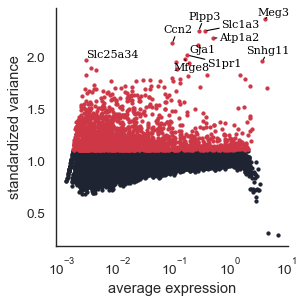

In [8]:
hge.pp.select_variable_genes(adata_CG, layer = None)
hge.pl.variable_genes(adata_CG,show_texts=True)    

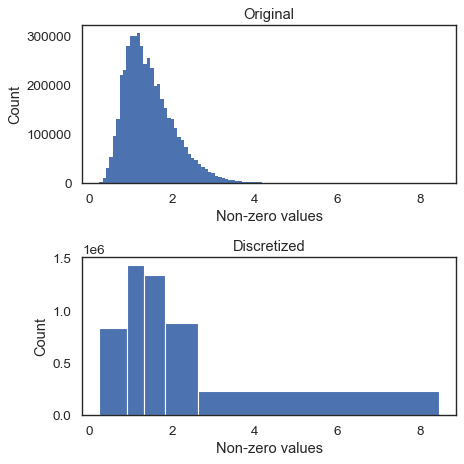

In [9]:
# discretize RNA expression
hge.tl.discretize(adata_CG,n_bins=5)
hge.pl.discretize(adata_CG,kde=False)

In [10]:
adata_CG_fltr = adata_CG[:, adata_CG.var['highly_variable']].copy()
adata_CG_fltr

AnnData object with n_obs × n_vars = 2487 × 2000
    obs: 'celltype'
    var: 'n_counts', 'n_cells', 'pct_cells', 'variances_norm', 'variances', 'means', 'highly_variable'
    uns: 'disc'
    layers: 'hge'

In [ ]:
g_in_db = []
for col in LR_df.columns:
    for value in LR_df[col]:
        if '_' in value:
            g_in_db.extend(value.split('_'))
        else:
            g_in_db.append(value)
g_in_db = list(set(g_in_db))
len(g_in_db)

In [ ]:
g_in_db = list(set(g_in_db) | set(markers['gene'].to_list()))
hvg = adata_CG.var[adata_CG.var['highly_variable']].index.tolist() 
ug = list(set(hvg) | set(g_in_db))

In [ ]:
adata_CG_fltr = adata_CG[:, adata_CG.var_names.isin(ug)].copy()
adata_CG_fltr

AnnData object with n_obs × n_vars = 2487 × 2000
    obs: 'celltype'
    var: 'n_counts', 'n_cells', 'pct_cells', 'variances_norm', 'variances', 'means', 'highly_variable'
    uns: 'disc'
    layers: 'hge'

### Peak

In [11]:
hge.pp.filter_peaks(adata_CP, min_n_cells=3)

Before filtering: 
2487 cells, 169148 peaks
Filter peaks based on min_n_cells
After filtering out low-expressed peaks: 
2487 cells, 167672 peaks


In [12]:
gene_info = pd.read_csv('/home/nas2/biod/yangchenghui/my_ych_project_P22brain/P22mousebrain_data/data/mm10_TSS.txt', sep = '\t')
gene_info = gene_info.rename(columns={'start': 'starts','end': 'ends','Gene': 'genes'})
gene_info.head()

,chr,starts,ends,genes
1,chr1,3466587,3513553,Gm1992
2,chr1,3205901,3671498,Xkr4
3,chr1,3905739,3986215,Gm37381
4,chr1,4292981,4409187,Rp1_2
5,chr1,3999557,4409241,Rp1


In [ ]:
hvg_genes = list(adata_CG_fltr.var_names)
peaks_to_filter = list(adata_CP.var_names)
filtered_peaks, genes_peaks = Processing.select_peaks_by_genes_location(gene_info, hvg_genes, peaks_to_filter)

Preprocessing gene_info:


27916it [00:00, 92968.97it/s]


Search the genes-peaks correspondence based on gene_info and scope:


27916it [01:13, 380.37it/s]


Search the filtered peaks:


100%|██████████| 1754/1754 [00:00<00:00, 151524.33it/s]

After filtering peaks: 55171


In [14]:
hge.pp.binarize(adata_CP)
adata_CP_fltr = adata_CP[:, filtered_peaks].copy()
adata_CP_fltr

AnnData object with n_obs × n_vars = 2487 × 55171
    obs: 'celltype'
    var: 'n_counts', 'n_cells', 'pct_cells'

### Motif(Get motif-peak score)

In [1]:
import subprocess
import pandas as pd

In [2]:
base_path = '/Applications/WHUer/notebooks/MultiChat-main/Datasets/ISSAAC/'

In [17]:
df = pd.DataFrame(adata_CP_fltr.X.toarray(), index=adata_CP_fltr.obs_names, columns=adata_CP_fltr.var_names)
df.to_csv(base_path+"HGEmb/CellPeak_fltr_count.csv")

To ensure the following packages are available in your R environment, use these commands:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("JASPAR2020")
BiocManager::install("JASPAR2016")
BiocManager::install("JASPAR2024")
BiocManager::install("JASPAR2018")

In [4]:
input_file = base_path+"HGEmb/CellPeak_fltr_count.csv"
output_dir = base_path+"HGEmb"

subprocess.run([
    "Rscript", "/Applications/WHUer/notebooks/MultiChat-main/MultiChat/Data_preprocessing/run_motif_matrix.R",
    input_file,
    output_dir
], check=True)

Loading required package: BiocFileCache
Loading required package: dbplyr

Attaching package: ‘dbplyr’

The following objects are masked from ‘package:dplyr’:

    ident, sql



Processing: jaspar2016 
Processing: jaspar2018 
Processing: jaspar2020 
Processing: jaspar2024 
Processing: encode 
Processing: homer 
Processing: cisbp 


CompletedProcess(args=['Rscript', '/Applications/WHUer/notebooks/MultiChat-main/MultiChat/Data_preprocessing/run_motif_matrix.R', '/Applications/WHUer/notebooks/MultiChat-main/Datasets/ISSAAC/HGEmb/CellPeak_fltr_count.csv', '/Applications/WHUer/notebooks/MultiChat-main/Datasets/ISSAAC/HGEmb'], returncode=0)

In [ ]:
jaspar2016 = pd.read_csv(base_path + 'HGEmb/jaspar_2016_peak_motif_matrix.txt', sep='\t')
jaspar2018 = pd.read_csv(base_path + 'HGEmb/jaspar_2018_peak_motif_matrix.txt', sep='\t')
jaspar2020 = pd.read_csv(base_path + 'HGEmb/jaspar_2020_peak_motif_matrix.txt', sep='\t')
jaspar2024 = pd.read_csv(base_path + 'HGEmb/jaspar_2024_peak_motif_matrix.txt', sep='\t')
encode = pd.read_csv(base_path + 'HGEmb/encode_peak_motif_matrix.txt', sep='\t')
homer = pd.read_csv(base_path + 'HGEmb/homer_peak_motif_matrix.txt', sep='\t')
cisbp = pd.read_csv(base_path + 'HGEmb/cisbp_peak_motif_matrix.txt', sep='\t')

In [ ]:
cisbp.columns = cisbp.columns.str.replace('.', '_') 
homer.columns = homer.columns.str.replace(r'\(.*\)', '', regex=True) 
encode.columns = [col.capitalize() for col in encode.columns]

In [ ]:
common_TFs_1 = set(l_r_tf_df['TF_Symbol']).intersection(set(jaspar2016.columns))
common_TFs_2 = set(l_r_tf_df['TF_Symbol']).intersection(set(jaspar2018.columns))
common_TFs_3 = set(l_r_tf_df['TF_Symbol']).intersection(set(jaspar2020.columns))
common_TFs_4 = set(l_r_tf_df['TF_Symbol']).intersection(set(jaspar2024.columns))
common_TFs_5 = set(l_r_tf_df['TF_Symbol']).intersection(set(encode.columns))
common_TFs_6 = set(l_r_tf_df['TF_Symbol']).intersection(set(homer.columns))
common_TFs_7 = set(l_r_tf_df['TF_Symbol']).intersection(set(cisbp.columns))

In [ ]:
len(common_TFs_1), len(common_TFs_2), len(common_TFs_3), len(common_TFs_4), len(common_TFs_5), len(common_TFs_6), len(common_TFs_7)

(14, 12, 11, 14, 55, 20, 109)

In [ ]:
common_TFs_all = common_TFs_1.union(common_TFs_2).union(common_TFs_3).union(common_TFs_4).union(common_TFs_5).union(common_TFs_6).union(common_TFs_7)
len(common_TFs_all)

116

In [ ]:
averaged_data = {}

for tf in common_TFs_all:
    tf_values = []
    
    if tf in jaspar2016.columns:
        tf_values.append(jaspar2016[tf])
    if tf in jaspar2018.columns:
        tf_values.append(jaspar2018[tf])
    if tf in jaspar2020.columns:
        tf_values.append(jaspar2020[tf])
    if tf in jaspar2024.columns:
        tf_values.append(jaspar2024[tf])
    if tf in cisbp.columns:
        tf_values.append(cisbp[tf])
    if tf in encode.columns:
        tf_values.append(encode[tf])
    if tf in homer.columns:
        tf_values.append(homer[tf])

    if tf_values:
        tf_mean = pd.concat(tf_values, axis=1).mean(axis=1, skipna=True)
        averaged_data[tf] = tf_mean

TFaveraged_df = pd.DataFrame(averaged_data)
TFaveraged_df

,Elk4,Ets1,Foxp3,Rxra,Nfkb1,Tcf7l1,Nr4a1,Id1,Smad3,Stat1,...,Smad5,Mlxipl,Nr4a2,Tcf7l2,Gli2,Pparg,Stat6,Sox9,Gtf2i,Ddit3
chr18.35771117.35771925,0.0,0.0,0.0,0.166667,1.0,0.0,1.0,0.0,0.000000,0.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,1.0,0.0
chr1.92473350.92474260,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.333333,0.0,0.0
chrX.100738882.100739496,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.000000,0.0,1.0
chr5.146253459.146254251,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,1.000000,0.0,...,0.0,2.0,0.0,0.0,0.5,0.0,0.0,0.333333,0.0,0.0
chr18.82535757.82536671,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr4.140943710.140944519,0.0,0.0,0.5,0.000000,1.0,0.0,0.0,0.0,0.666667,2.0,...,0.0,0.0,0.0,0.0,0.5,1.0,2.0,0.000000,0.0,0.0
chr5.100069878.100070751,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
chr2.102620457.102621387,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.000000,1.0,...,0.0,0.0,1.0,0.0,0.5,0.0,2.0,0.000000,0.0,0.0
chr3.153835431.153836277,0.0,0.0,0.5,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.5,0.5,1.0,0.0,0.000000,0.0,0.0


In [ ]:
TFaveraged_df.index = TFaveraged_df.index.map(lambda s: f"{s.split('.')[0]}:{s.split('.')[1]}-{s.split('.')[2]}")
TFaveraged_df.head()

,Elk4,Ets1,Foxp3,Rxra,Nfkb1,Tcf7l1,Nr4a1,Id1,Smad3,Stat1,...,Smad5,Mlxipl,Nr4a2,Tcf7l2,Gli2,Pparg,Stat6,Sox9,Gtf2i,Ddit3
chr18:35771117-35771925,0.0,0.0,0.0,0.166667,1.0,0.0,1.0,0.0,0.0,0.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,1.0,0.0
chr1:92473350-92474260,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.333333,0.0,0.0
chrX:100738882-100739496,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.000000,0.0,1.0
chr5:146253459-146254251,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,2.0,0.0,0.0,0.5,0.0,0.0,0.333333,0.0,0.0
chr18:82535757-82536671,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
TFaveraged_df.to_csv(base_path + 'HGEmb/TFaveraged_RE.csv')

In [15]:
peak_motif_matrix = pd.read_csv(base_path+"HGEmb/TFaveraged_RE.csv", sep = ",", index_col=0)
peak_motif_matrix.index = peak_motif_matrix.index.str.replace(r'(\w+)\.(\d+)\.(\d+)', r'\1:\2-\3', regex=True)
peak_motif_matrix

,Elk4,Foxo6,Nfkb1,Myb,Tcf3,Jund,Pou1f1,Rora,Stat3,Zfp128,...,Mybl2,Nfatc2,Pbx1,Smad2,Myc,E2f4,Zfp282,Esrrb,Gli1,Mitf
chr1:33993838-33994758,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:163141133-163141993,0.000000,1.0,0.0,0.0,0.666667,1.0,0.5,0.0,0.5,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
chr3:98386937-98387783,0.000000,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0
chr10:4670670-4671542,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr8:105470983-105471875,0.000000,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr7:79726820-79727572,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
chr13:38509751-38510435,0.000000,0.5,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr4:124861871-124862773,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
chr15:91958353-91959260,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
sub = peak_motif_matrix.loc[peak_motif_matrix.index.intersection(filtered_peaks)]
peak_motif_matrix = sub.copy()

In [17]:
adata_PM = AnnData(peak_motif_matrix)
adata_PM

AnnData object with n_obs × n_vars = 52134 × 118

In [18]:
hge.pp.binarize(adata_PM)
adata_PM

AnnData object with n_obs × n_vars = 52134 × 118

In [19]:
filtered_peaks = list(peak_motif_matrix.index)
adata_CP_fltr = adata_CP[:, filtered_peaks].copy() 
adata_CP_fltr

AnnData object with n_obs × n_vars = 2487 × 52134
    obs: 'celltype'
    var: 'n_counts', 'n_cells', 'pct_cells'

### Generate heterogeneous graph

In [20]:
hge.tl.gen_graph(list_CP=[adata_CP_fltr],
                list_CG=[adata_CG_fltr],
                list_PM=[adata_PM],
                copy=False,
                use_highly_variable=False,
                use_top_pcs=False,
                dirname='graph0')

`hge` does not exist in anndata 0 in `list_CP`.`.X` is being used instead.
relation0: source: C, destination: P
#edges: 6989947
`hge` does not exist in anndata 0 in `list_PM`.`.X` is being used instead.
relation1: source: P, destination: M
#edges: 856311
relation2: source: C, destination: G
#edges: 30999
relation3: source: C, destination: G
#edges: 61709
relation4: source: C, destination: G
#edges: 77808
relation5: source: C, destination: G
#edges: 87855
relation6: source: C, destination: G
#edges: 47853
Total number of edges: 8152482
Writing graph file "pbg_graph.txt" to "/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/ISSAAC/HGEmb/pbg/graph0" ...
Finished.


## Training

In [21]:
hge.settings.pbg_params

{'entity_path': '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/ISSAAC/HGEmb/pbg/graph0/input/entity',
 'edge_paths': ['/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/ISSAAC/HGEmb/pbg/graph0/input/edge'],
 'checkpoint_path': '',
 'entities': {'C': {'num_partitions': 1},
  'G': {'num_partitions': 1},
  'P': {'num_partitions': 1},
  'M': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'P',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'P', 'rhs': 'M', 'operator': 'none', 'weight': 0.2},
  {'name': 'r2',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': np.float64(1.0)},
  {'name': 'r3',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': np.float64(2.0)},
  {'name': 'r4',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': np.float64(3.0)},
  {'name': 'r5',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': np.float64(4.0)},
  {'name': 'r6',
   'lhs': 'C',
   'rhs': 'G',


In [22]:
# modify parameters
dict_config = hge.settings.pbg_params.copy()
# dict_config['num_epochs'] = 10
dict_config['workers'] = 12 #The number of CPUs.

In [ ]:
hge.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model')

Auto-estimated weight decay is 1.844814E-03
`.settings.pbg_params['wd']` has been updated to 1.844814E-03
Converting input data ...
[2025-06-20 14:18:36.914540] Using the 7 relation types given in the config
[2025-06-20 14:18:36.915149] Searching for the entities in the edge files...
[2025-06-20 14:19:14.583319] Entity type C:
[2025-06-20 14:19:14.584645] - Found 6843 entities
[2025-06-20 14:19:14.585046] - Removing the ones with fewer than 1 occurrences...
[2025-06-20 14:19:14.587212] - Left with 6843 entities
[2025-06-20 14:19:14.587621] - Shuffling them...
[2025-06-20 14:19:14.590760] Entity type G:
[2025-06-20 14:19:14.591155] - Found 3170 entities
[2025-06-20 14:19:14.591459] - Removing the ones with fewer than 1 occurrences...
[2025-06-20 14:19:14.592302] - Left with 3170 entities
[2025-06-20 14:19:14.592680] - Shuffling them...
[2025-06-20 14:19:14.594229] Entity type P:
[2025-06-20 14:19:14.594580] - Found 63051 entities
[2025-06-20 14:19:14.594881] - Removing the ones with few

/home/zhencaiwei/anaconda3/envs/env_simba_dev/lib/python3.12/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:


[2025-06-20 14:21:16.993539] - Processed 19207980 edges in total
Starting training ...


/home/zhencaiwei/anaconda3/envs/env_simba_dev/lib/python3.12/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/home/zhencaiwei/anaconda3/envs/env_simba_dev/lib/python3.12/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/home/zhencaiwei/anaconda3/envs/env_simba_dev/lib/python3.12/site-packages/torchbiggraph/tensorlist.py:86:

Finished


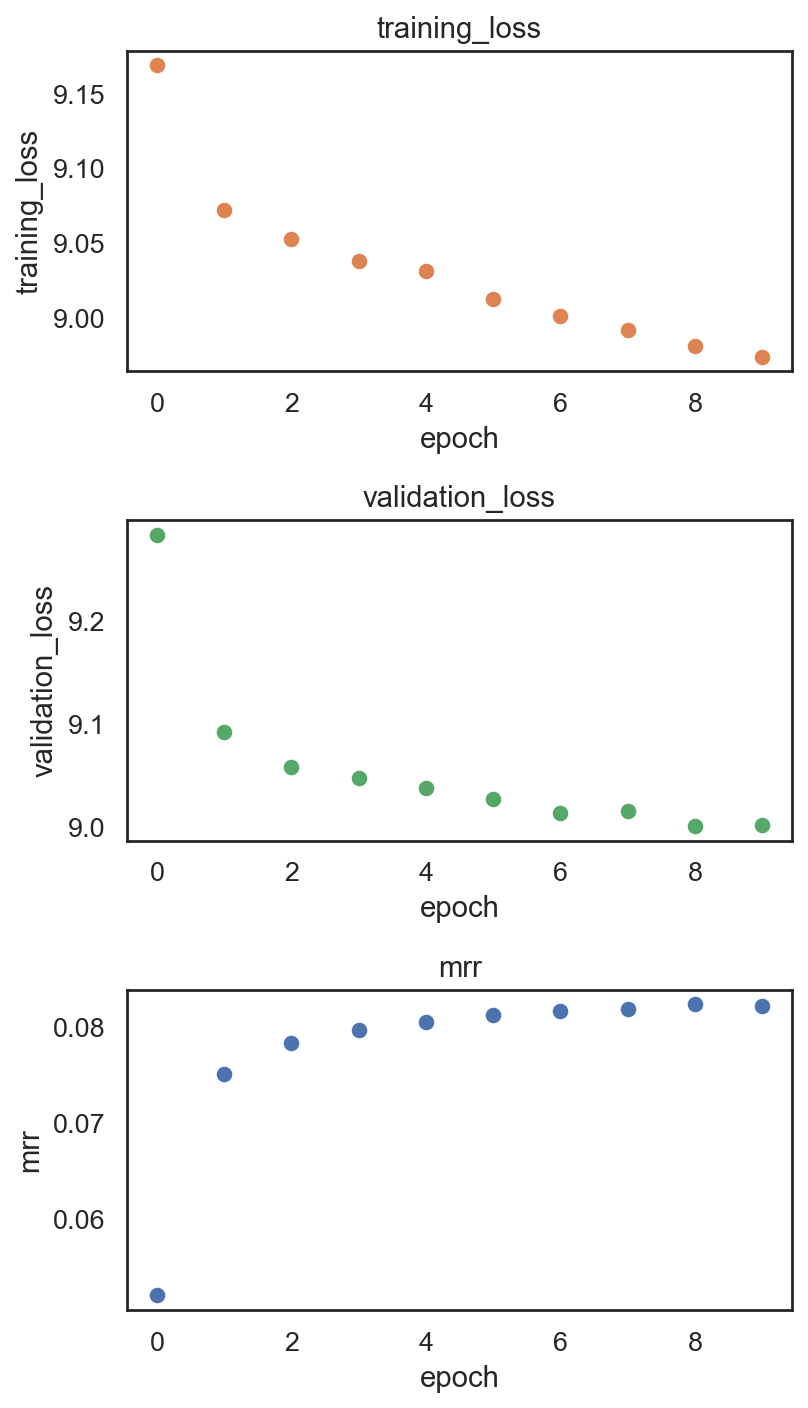

In [ ]:
hge.settings.pbg_params = dict_config
hge.pl.pbg_metrics(fig_ncol=1)

## Post-training analysis

In [ ]:
dict_adata = hge.read_embedding()
dict_adata

{'C': AnnData object with n_obs × n_vars = 2552 × 50,
 'P': AnnData object with n_obs × n_vars = 55411 × 50,
 'M': AnnData object with n_obs × n_vars = 107 × 50,
 'G': AnnData object with n_obs × n_vars = 2000 × 50}

In [ ]:
adata_C = dict_adata['C']  # embeddings for cells
adata_G = dict_adata['G']  # embeddings for genes
adata_P = dict_adata['P']  # embeddings for peaks
adata_M = dict_adata['M']  # embeddings for motifs
adata_M.obs.index = 'M_'+adata_M.obs.index

In [ ]:
adata_C.obs["entity_anno"] = "Cell"
adata_G.obs["entity_anno"] = "Gene"
adata_P.obs["entity_anno"] = "Peak"
adata_M.obs["entity_anno"] = "Motif"

visualize embeddings of cells

In [ ]:
## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CG[adata_C.obs_names,:].obs['celltype'].copy() #label
adata_C

AnnData object with n_obs × n_vars = 2552 × 50
    obs: 'entity_anno', 'celltype'

In [ ]:
hge.tl.umap(adata_C,n_neighbors=15,n_components=2)

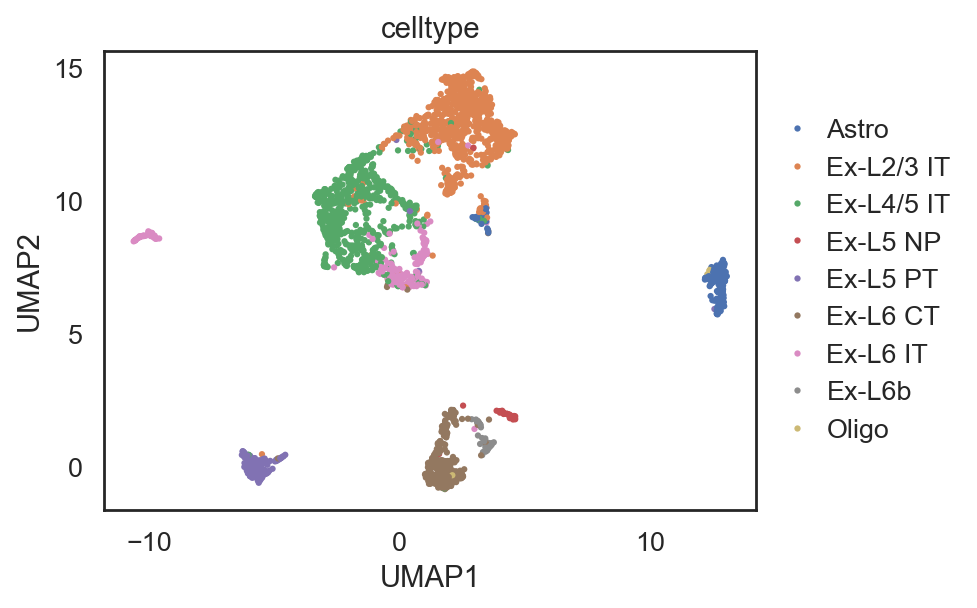

In [ ]:
hge.pl.umap(adata_C,
           color=['celltype'],
           fig_size=(6,4),
           drawing_order='random')

visualize embeddings of cells and genes

In [ ]:
adata_all_CG = hge.tl.embed(adata_ref=adata_C,
                           list_adata_query=[adata_G])

Performing softmax transformation for query data 0;


In [ ]:
## add annotations of all entities
adata_all_CG.obs['entity_anno'] = ""
adata_all_CG.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all_CG.obs.loc[adata_C.obs_names, 'celltype'].tolist()
adata_all_CG.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'

adata_all_CG.obs.head()

,entity_anno,celltype,id_dataset
TTTGTGTTCCAATCCC-1,Ex-L2/3 IT,Ex-L2/3 IT,ref
GGATAGGAGATGCGCA-1,Ex-L2/3 IT,Ex-L2/3 IT,ref
CCTGCTATCAGGTCTA-1,Astro,Astro,ref
CTCTCGAGTGCGTAGA-1,Ex-L5 NP,Ex-L5 NP,ref
CTGGGACCAACTAGAA-1,Ex-L4/5 IT,Ex-L4/5 IT,ref


In [ ]:
hge.tl.umap(adata_all_CG,n_neighbors=15,n_components=2)

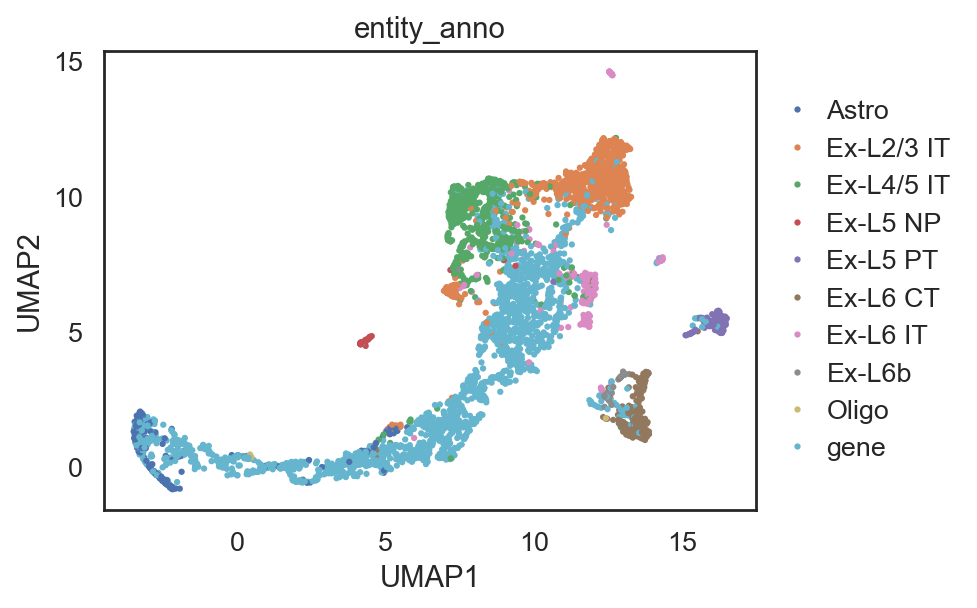

In [ ]:
hge.pl.umap(adata_all_CG,
           color=['entity_anno'],
           fig_size=(6,4),
           drawing_order='random')

visualize embeddings of all entities including cells, genes, peaks and motifs

In [ ]:
adata_all = hge.tl.embed(adata_ref=adata_C,
                        list_adata_query=[adata_G, adata_P, adata_M])

Performing softmax transformation for query data 0;
Performing softmax transformation for query data 1;
Performing softmax transformation for query data 2;


In [ ]:
## add annotations of all entities
adata_all.obs['entity_anno'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all.obs.loc[adata_C.obs_names, 'celltype'].tolist()
adata_all.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'
adata_all.obs.loc[adata_P.obs_names, 'entity_anno'] = 'peak'
adata_all.obs.loc[adata_M.obs_names, 'entity_anno'] = 'motif'

adata_all.obs.head()

,entity_anno,celltype,id_dataset
TTTGTGTTCCAATCCC-1,Ex-L2/3 IT,Ex-L2/3 IT,ref
GGATAGGAGATGCGCA-1,Ex-L2/3 IT,Ex-L2/3 IT,ref
CCTGCTATCAGGTCTA-1,Astro,Astro,ref
CTCTCGAGTGCGTAGA-1,Ex-L5 NP,Ex-L5 NP,ref
CTGGGACCAACTAGAA-1,Ex-L4/5 IT,Ex-L4/5 IT,ref


In [ ]:
hge.tl.umap(adata_all,n_neighbors=15,n_components=2,n_jobs=20)

/home/nas2/biod/yangchenghui/simba-dev/simba/plotting/_plot.py:1076: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['color'] = dict()


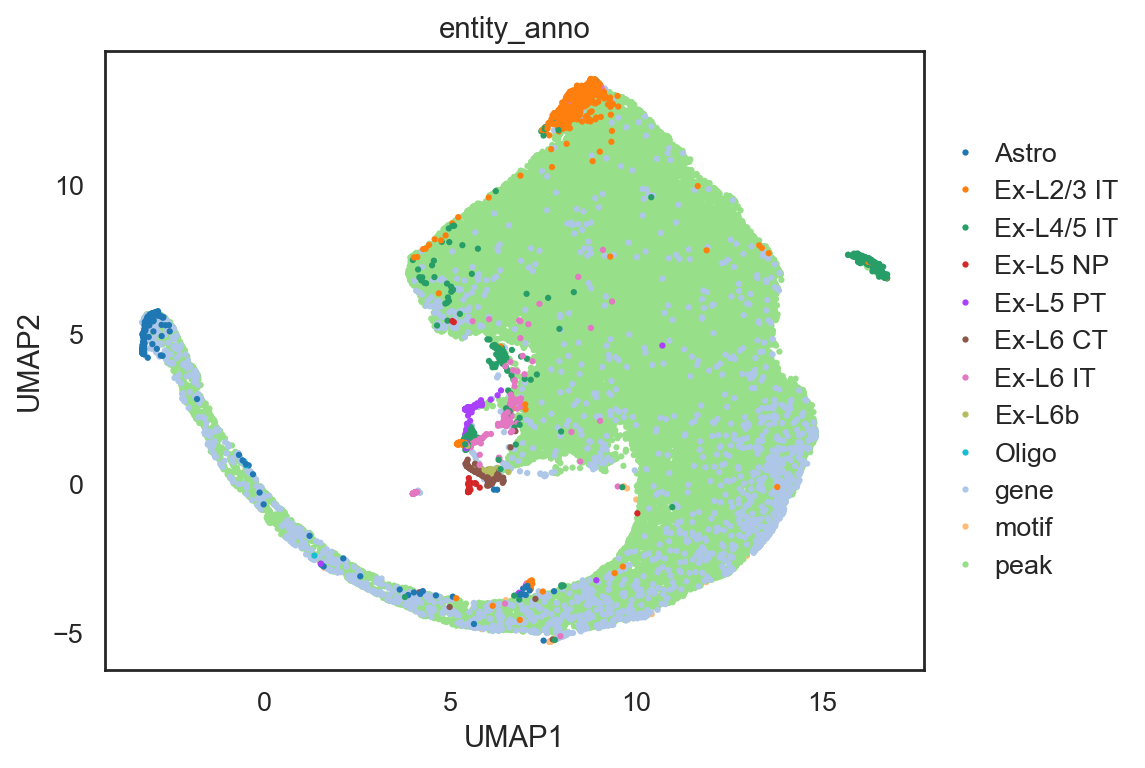

In [ ]:
hge.pl.umap(adata_all[::-1,],
           color=['entity_anno'],
           fig_size=(7,5),
           drawing_order='original')

after si.tl.embed()

In [ ]:
adata_all0 = hge.tl.embed(adata_ref=adata_C,
                        list_adata_query=[adata_G, adata_P, adata_M])

Performing softmax transformation for query data 0;
Performing softmax transformation for query data 1;
Performing softmax transformation for query data 2;


In [ ]:
adata_all0.obs['entity_anno'] = ""
adata_all0.obs.loc[adata_C.obs_names, 'entity_anno'] = "Cell"
adata_all0.obs.loc[adata_G.obs_names, 'entity_anno'] = 'Gene'
adata_all0.obs.loc[adata_P.obs_names, 'entity_anno'] = 'Peak'
adata_all0.obs.loc[adata_M.obs_names, 'entity_anno'] = 'Motif'
adata_all0.obs

,entity_anno,celltype,id_dataset
TTTGTGTTCCAATCCC-1,Cell,Ex-L2/3 IT,ref
GGATAGGAGATGCGCA-1,Cell,Ex-L2/3 IT,ref
CCTGCTATCAGGTCTA-1,Cell,Astro,ref
CTCTCGAGTGCGTAGA-1,Cell,Ex-L5 NP,ref
CTGGGACCAACTAGAA-1,Cell,Ex-L4/5 IT,ref
...,...,...,...
M_Hoxa11,Motif,NaN,query_2
M_Arnt,Motif,NaN,query_2
M_Nkx2-5(var.2),Motif,NaN,query_2
M_Rhox11,Motif,NaN,query_2


In [ ]:
si.tl.umap(adata_all0,n_neighbors=15,n_components=2)

/home/yangchenghui/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


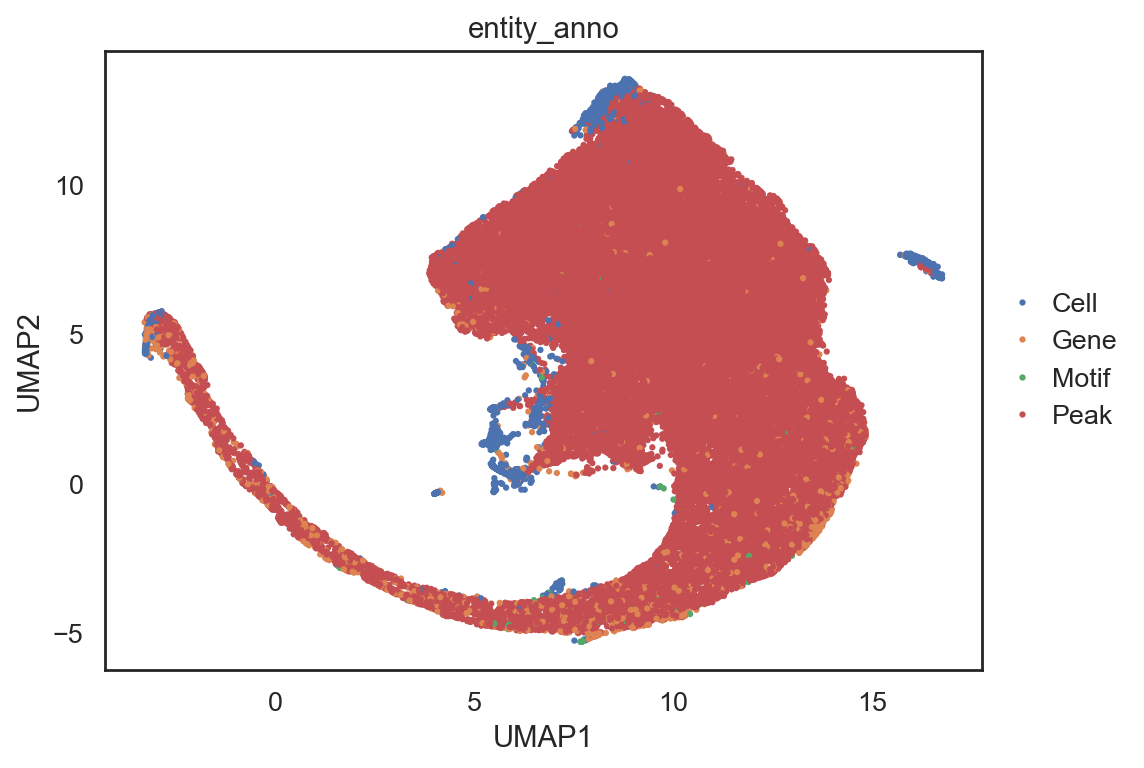

In [ ]:
hge.pl.umap(adata_all0,
           color=['entity_anno'],
           fig_size=(7,5),
           drawing_order='random')

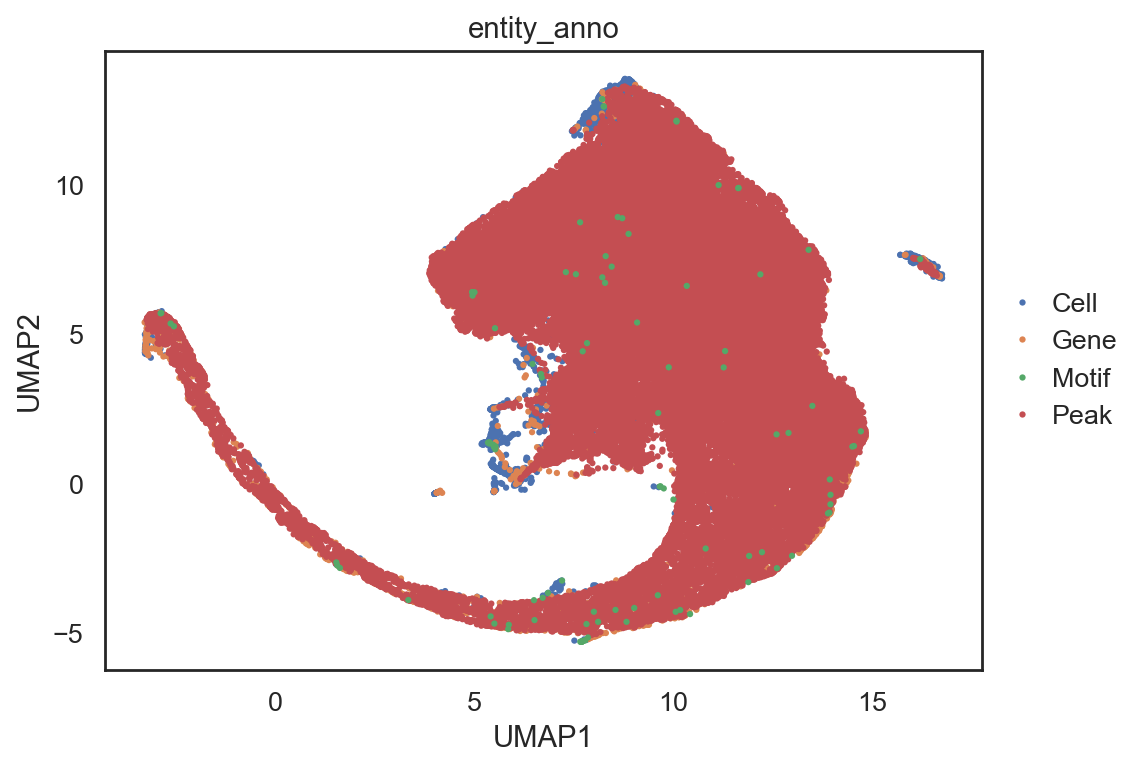

In [ ]:
hge.pl.umap(adata_all0,
           color=['entity_anno'],
           fig_size=(7,5),
           drawing_order='original')

In [ ]:
adata_all0.write(base_path+"HGE/ISSAAC_HGE_all_adata.h5ad")

## Embedding of various entities

In [ ]:
import anndata
adata_all = anndata.read_h5ad(base_path+"HGE/ISSAAC_HGE_all_adata.h5ad")
adata_all

AnnData object with n_obs × n_vars = 60070 × 50
    obs: 'entity_anno', 'celltype', 'id_dataset'
    uns: 'color'
    obsm: 'X_umap'

In [ ]:
Cell_emd = adata_all[adata_all.obs["entity_anno"] == "Cell"]
Gene_emd = adata_all[adata_all.obs["entity_anno"] == "Gene"]
Peak_emd = adata_all[adata_all.obs["entity_anno"] == "Peak"]
Motif_emd = adata_all[adata_all.obs["entity_anno"] == "Motif"]
Cell_emd, Gene_emd, Peak_emd, Motif_emd

(View of AnnData object with n_obs × n_vars = 2552 × 50
     obs: 'entity_anno', 'celltype', 'id_dataset'
     uns: 'color'
     obsm: 'X_umap',
 View of AnnData object with n_obs × n_vars = 2000 × 50
     obs: 'entity_anno', 'celltype', 'id_dataset'
     uns: 'color'
     obsm: 'X_umap',
 View of AnnData object with n_obs × n_vars = 55411 × 50
     obs: 'entity_anno', 'celltype', 'id_dataset'
     uns: 'color'
     obsm: 'X_umap',
 View of AnnData object with n_obs × n_vars = 107 × 50
     obs: 'entity_anno', 'celltype', 'id_dataset'
     uns: 'color'
     obsm: 'X_umap')

# Step5: Get peak-TG score

In [2]:
base_path = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/ISSAAC/'

In [3]:
cicero_conn = pd.read_csv(base_path + 'inputs/ISSACC_cicero_connections_mm10.txt',sep='\t')
cicero_conn['coaccess'] = abs(cicero_conn['coaccess'])
cicero_conn.head()

,Peak1,Peak2,coaccess
1,chr10:100010013-100010856,chr10:99824263-99825113,0.000000
2,chr10:100010013-100010856,chr10:99825636-99826557,0.000259
3,chr10:100010013-100010856,chr10:99857774-99858602,0.006728
4,chr10:100010013-100010856,chr10:99861766-99862642,0.001111
5,chr10:100010013-100010856,chr10:99881727-99882577,0.000111


In [4]:
atac = pl.read_csv(base_path + 'inputs/ATACmatrix.csv')
atac = atac.to_pandas().set_index(atac.columns[0]) 
atac

,chr1:3094744-3095664,chr1:3119738-3120157,chr1:3120244-3120621,chr1:3121259-3121993,chr1:3180886-3181804,chr1:3199869-3200491,chr1:3204692-3205420,chr1:3210734-3211456,chr1:3227795-3228596,chr1:3250441-3251363,...,chrY:90787768-90788363,chrY:90788481-90789181,chrY:90797265-90797883,chrY:90798857-90799639,chrY:90800206-90801101,chrY:90803028-90803860,chrY:90804581-90805497,chrY:90807265-90807966,chrY:90808427-90809223,chrY:90813367-90814157
,,,,,,,,,,,,,,,,,,,,,
CCCTAGTTCGTTGTTT-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.533234,0.0,0.799851,0.266617,0.0
GCTGTTCTCGTTGTTT-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.847961,0.847961,0.0
CGCTATCTCGTTGTTT-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,1.734605,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
ACCAAACAGCGTGTTT-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.580484,0.0,1.160968,0.000000,0.0
ATTGTCTTCCATGTTT-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.433407,...,0.0,0.0,0.000000,0.0,1.733628,0.000000,0.0,0.433407,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTAGCGGGTTCCCAAA-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
TACCTCGCATCCCAAA-1,1.746572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
GCGATTACATCCCAAA-1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,5.385030,0.0,0.000000,0.000000,0.0,2.692515,0.000000,0.0


In [5]:
gene_info = pd.read_csv(base_path+'inputs/mm10_TSS.txt', index_col=0, sep='\t') 
gene_info = gene_info.rename(columns={'start': 'starts','end': 'ends','Gene': 'genes'}) 
gene_info

,chr,starts,ends,genes
1,chr1,3466587,3513553,Gm1992
2,chr1,3205901,3671498,Xkr4
3,chr1,3905739,3986215,Gm37381
4,chr1,4292981,4409187,Rp1_2
5,chr1,3999557,4409241,Rp1
...,...,...,...,...
27917,chrY,90603501,90605864,Gm28300
27918,chrY,90665346,90667625,Gm28301
27919,chrY,90754513,90754821,Gm21860
27920,chrY,90784738,90816464,Erdr1


In [6]:
markers = pd.read_csv(base_path+'inputs/marker_genes380.csv', sep=',',index_col=None) 

## Marker gene up 2kb

In [7]:
marker_lst = markers['gene'].tolist()
marker_lst = list(set(marker_lst))
peak_lst = atac.columns.tolist()

In [8]:
filtered_peaks, genes_peaks = Processing.select_peaks_by_genes_location(gene_info, marker_lst, peak_lst, scope = 2000)

Preprocessing gene_info:


27916it [00:00, 124162.47it/s]


Search the genes-peaks correspondence based on gene_info and scope:


27916it [00:16, 1715.47it/s]


Search the filtered peaks:


100%|██████████| 283/283 [00:00<00:00, 1952282.95it/s]

After filtering peaks: 366


In [9]:
filtered_peaks = pd.DataFrame(filtered_peaks, columns=['peaks']) 
filtered_peaks.head()

,peaks
0,chr14:70889578-70890453
1,chr4:33924380-33925330
2,chr14:84442973-84443701
3,chr3:55242245-55243027
4,chr6:135713267-135714331


In [ ]:
import json

genes_peaks_serializable = {key: list(value) if isinstance(value, set) else value for key, value in genes_peaks.items()}
with open(base_path + 'inputs/genes_peaks_up2kb_overlap.json', 'w') as f:
    json.dump(genes_peaks_serializable, f)

## Set cicero cutoff = 0.5

In [ ]:
genes_peaks_cicero = {}
cicero_cotoff = 0.5

filtered_cicero = cicero_conn[abs(cicero_conn['coaccess']) >= cicero_cotoff]

for g_item, p_item_lst in tqdm(genes_peaks.items(), desc="Processing genes"):
    g_item_dict = Processing.cicero_peaks_peaks(filtered_cicero, p_item_lst, cicero_cotoff)
    
    if g_item_dict:
        combined_list = list({item for sublist in g_item_dict.values() for item in sublist})
        genes_peaks_cicero[g_item] = combined_list

Processing peakitems: 100%|██████████| 2/2 [00:00<00:00, 482.55it/s]

Processing peakitems:   0%|          | 0/1 [00:00<?, ?it/s]

Processing genes: 100%|██████████| 283/283 [00:01<00:00, 197.98it/s]


In [ ]:
genes_all_lst = []
peaks_all_lst = []
scores_all_lst = []  
cicero_cotoff = 0.5

for g_item, p_item_lst in tqdm(genes_peaks.items(), desc="Processing genes"):
    peaks_lst, scores_lst = Processing.cicero_peaks_peaks_score(cicero_conn, p_item_lst, cicero_cotoff)
    
    if peaks_lst:  
        genes_all_lst.extend([g_item] * len(peaks_lst))
        peaks_all_lst.extend(peaks_lst)
        scores_all_lst.extend(scores_lst)

Processing genes: 100%|██████████| 283/283 [00:14<00:00, 19.84it/s]


In [15]:
TG_RE_score_df = pd.DataFrame({'genes': genes_all_lst, 'peaks': peaks_all_lst, 'scores': scores_all_lst})
TG_RE_score_df.head()

,genes,peaks,scores
0,Sulf1,chr1:12764362-12765242,0.522441
1,Acsl3,chr1:78563294-78563676,0.518422
2,Acsl3,chr1:78567950-78568818,0.566656
3,Acsl3,chr1:78590480-78591228,0.662717
4,Acsl3,chr1:78593603-78594466,0.694573
